# 读取和配置最大3个lmx不同时钟
# 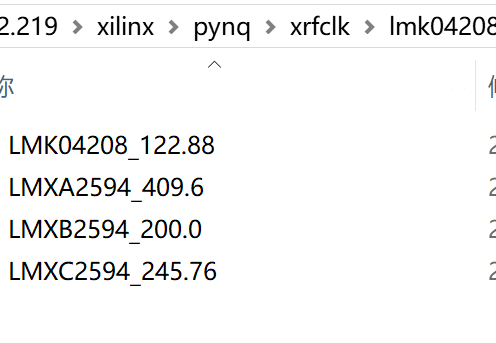
## 注意lmx命名规则为LMXA2594_freq.txt

## step 0: 引用必要的库

In [1]:
import os
import xrfclk 

## step 1: 使用xrfclk的_find_devices() 方法找到系统的lmk,lmx设备

In [2]:
def find_lmclk_devices():
    xrfclk.xrfclk._find_devices()
find_lmclk_devices()

In [3]:
xrfclk.lmk_devices

[{'spi_device': PosixPath('/dev/spidev1.1'),
  'compatible': 'lmk04208',
  'num_bytes': 4}]

In [4]:
xrfclk.lmx_devices

[{'spi_device': PosixPath('/dev/spidev1.3'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.2'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.0'), 'compatible': 'lmx2594'}]

## step 2: 指定一个存储有时钟配置文件的位置，通常时钟配置文件放置在以lmk命名的文件夹里
### 例如时钟配置文件放置在 pynq/xrfclk/

In [5]:
loc = '/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/'

## step 3: 通常存在一个lmk，一至三个lmx

In [6]:
lmclk_loc = '' # 目录字符串
lmk_loc = ''   # 含文件名的完整路径字符串
lmx_locs = []  # 多个完整路径字符串列表

## step 4: 确定存在时钟配置txt文件的文件夹

In [7]:
for root, dirs, files in os.walk(loc):
        for d in dirs:
            for lmk in xrfclk.lmk_devices:
                if d == lmk['compatible']:
                    lmclk_loc = os.path.join(root, d)
                    break

In [8]:
lmclk_loc

'/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208'

## step 5: 存储所有lmk, lmx文件

In [9]:
for file in os.listdir(lmclk_loc):
        if file.endswith('.txt'):
            if 'LMK' in file:
                lmk_loc = os.path.join(lmclk_loc, file)
            elif 'LMX' in file:
                lmx_locs.append(os.path.join(lmclk_loc, file))
lmx_locs.sort()

In [10]:
lmk_loc

'/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMK04208_122.88.txt'

In [11]:
lmx_locs

['/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXA2594_409.6.txt',
 '/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXB2594_200.0.txt',
 '/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXC2594_245.76.txt']

## step 6: 存储lmk名称和频率值（MHz）和配置寄存器数据

In [12]:
lmk_name = lmk_loc.split('/')[-1]
lmk = lmk_name.strip('.txt').split('_')

with open(lmk_loc, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmk_reg = [int(r.split('\t')[-1], 16) for r in reg]

## step 7: 构建clk_props字典,仅lmk

In [13]:
clk_props = {
    'lmk': {
        'file': lmk_name,
        'loc':  lmk_loc,
        'chip': lmk[0],
        'freq': lmk[1],
        'reg':  lmk_reg
    }
}

## step 8: 存储所有lmx的名称，频率值，各存储器数据

In [14]:
lmxs = []
lmxs_reg = []
for lmx in lmx_locs:
    temp = lmx.split('/')[-1]
    lmx_split = temp.strip('.txt').split('_')
    lmxs.append(lmx_split)
    with open(lmx, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmxs_reg.append([int(r.split('\t')[-1], 16) for r in reg])

## step 9: 扩展clk_props字典，lmx关键字段用LMXA2594类似表示

In [15]:
for i in range(len(lmxs)):
    clk_props.update(
        {lmxs[i][0]: {                 # LMXA2594
            'file': lmxs[i][0],        # LMXA2594
            'loc' : lmx_locs[i],       # /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXA2594_409.6.txt
            'chip': lmxs[i][0],        # LMXA2594
            'freq': lmxs[i][1],        # 409.6
            'reg' : lmxs_reg[i]        # 各寄存器数据
        }
        }
    )

## step 10: 配置lmk

In [16]:
for lmk in xrfclk.lmk_devices:
    xrfclk.xrfclk._write_LMK_regs(clk_props['lmk']['reg'], lmk)

## step 11: 配置lmxs

In [18]:
for i in range(len(lmxs)):
    xrfclk.xrfclk._write_LMX_regs(clk_props[lmxs[i][0]]['reg'], xrfclk.lmx_devices[i])